In [ ]:
!nvidia-smi

Fri Jan 14 17:37:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import pickle
import string
import csv

In [ ]:
with open("positives.pkl", "rb") as fp:
	positives_datastore = pickle.load(fp)

In [ ]:
data_positive = []
idx = 1
for _, text in positives_datastore:
  text = text.replace(",", "")
  text = text.replace(".", "")
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  table2 = str.maketrans('', '', string.digits)
  stripped = [w.translate(table) for w in words]
  stripped2 = [w.translate(table2) for w in stripped]
  text = " ".join(stripped2)
  text = text.strip()
  data_positive.append([idx, text, "positive"])
  idx += 1

In [ ]:
header = ["index", "text", "emotion"]

with open('positives.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  writer.writerows(data_positive)
f.close()

In [ ]:
df_positive = pd.read_csv("positives.csv")
df_positive.head(5)

In [ ]:
with open("negatives.pkl", "rb") as fp:
	negatives_datastore = pickle.load(fp)

In [ ]:
data_negative = []
idx = 1
for _, text in negatives_datastore:
  text = text.replace(",", "")
  text = text.replace(".", "")
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  table2 = str.maketrans('', '', string.digits)
  stripped = [w.translate(table) for w in words]
  stripped2 = [w.translate(table2) for w in stripped]
  text = " ".join(stripped2)
  text = text.strip()
  data_negative.append([idx, text, "negative"])
  idx += 1

In [ ]:
header = ["index", "text", "emotion"]

with open('negatives.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  writer.writerows(data_negative)
f.close()

In [ ]:
df_positive = pd.read_csv("positives.csv")
df_negative = pd.read_csv("negatives.csv")

In [ ]:
df_positive = df_positive[['text', 'emotion']]
df_negative = df_negative[['text', 'emotion']]

In [ ]:
len(df_positive)

15240

In [ ]:
len(df_negative)

20626

In [ ]:
# Joining two dataframes
df_emotions = pd.concat([df_positive, df_negative])

In [ ]:
df_emotions = pd.read_csv("/content/emotions_datastore.csv")
df_emotions.head()

,Unnamed: 0,text,emotion
0,0,He was indeed fortunate in his friends,positive
1,1,I hope people will be courageous enough to spe...,positive
2,2,Try softening the edges a bit by having the ki...,positive
3,3,Hes never more annoying than when hes trying t...,negative
4,4,Some noisy students were bawling for more food,negative


In [ ]:
# Shuffling Dataframe
df_emotions = df_emotions.sample(frac=1).reset_index(drop=True)

In [ ]:
df_emotions.sample(10)

,text,emotion
25343,In the stock market smashed more records than...,negative
28046,Like Lindbergh Signs left on a foggy drizzly m...,negative
17423,It occurred to him that it might be easier to ...,positive
16170,When they tried to arrest him he suddenly went...,negative
28509,The Umpire it had to be Heavenly Father,positive
9416,She did her best to make herself agreeable,positive
32207,He did not find the question cryptic or bizarre,negative
14364,Copyright protects your work from being commer...,negative
3980,Hes got floppy blond hair thats always falling...,negative
15837,She became rather indignant over suggestions t...,negative


In [ ]:
# Saving to csv
df_emotions.to_csv("emotions_datastore.csv")

#Model Building and Training

In [ ]:
df_emotions = pd.read_csv("/content/emotions_datastore.csv")
df_emotions.head()

,Unnamed: 0,text,emotion
0,0,He was indeed fortunate in his friends,positive
1,1,I hope people will be courageous enough to spe...,positive
2,2,Try softening the edges a bit by having the ki...,positive
3,3,Hes never more annoying than when hes trying t...,negative
4,4,Some noisy students were bawling for more food,negative


In [ ]:
df_emotions = df_emotions[['text', 'emotion']]

In [ ]:
len(df_emotions)

35866

In [ ]:
df_emotions.dropna(inplace=True)

In [ ]:
len(df_emotions)

35832

In [ ]:
sentences = []
labels = []
for item in df_emotions.iterrows():
  sentences.append(item[1]['text'])
  labels.append(item[1]['emotion'])

In [ ]:
print(len(sentences), len(labels))

35832 35832


In [ ]:
labels[0]

'positive'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer(oov_token="<0OV>")
tokenizer.fit_on_texts(sentences)

In [ ]:
tokenizer

In [ ]:
total_words = len(tokenizer.word_index) + 1

In [ ]:
total_words

29603

In [ ]:
max_length = max([len(sentence) for sentence in sentences])
print(max_length)

461


In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(sequences, maxlen=max_length, truncating="post", padding="post")

In [ ]:
labels_df = []
for label in labels:
  if label == 'positive':
    labels_df.append(1)
  elif label == 'negative':
    labels_df.append(0)

In [ ]:
len(labels_df)

35832

In [ ]:
labels_f = to_categorical(labels_df, num_classes=2)

In [ ]:
from sklearn.model_selection import train_test_split

padded_training, padded_testing, training_labels, testing_labels = train_test_split(padded_sentences, labels_f, test_size=0.20)

In [ ]:
vocab_size = total_words
embedding_dim = 200

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 461, 200)          5920600   
                                                                 
 bidirectional (Bidirectiona  (None, 461, 200)         240800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               59648     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [ ]:
history = model.fit(
    padded_training,
    training_labels,
    epochs=30,
    validation_data=(padded_testing, testing_labels),
    batch_size=128
)


In [ ]:
model.save("text_emotions.h5")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp '/content/text_emotions.h5' '/content/drive/MyDrive/Models(AI)'

In [ ]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string.capitalize())
  plt.legend([string, 'val_'+string])
  plt.show()

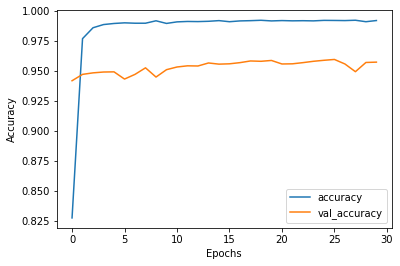

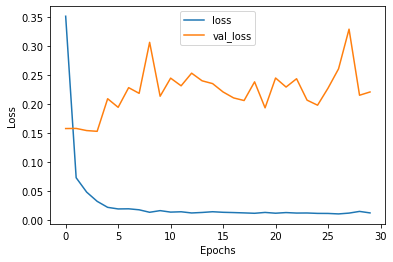

In [ ]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [ ]:
!cp '/content/tokenizer.pickle' '/content/drive/MyDrive/Models(AI)'

In [ ]:
sentence = "His whole family knows he loves you."
pred_sequence = tokenizer.texts_to_sequences(sentence)
pred_padded = pad_sequences(pred_sequence, maxlen=max_length, padding="post", truncating="post")
prediction = model.predict(pred_padded)
print(prediction)

In [ ]:
import numpy as np
np.argmax(prediction)

1